# Hashtags VS Real Clear Politics: 
# VA Gov 2021 Race Oct 8 - Nov 2

In [1]:
#import the libraries
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
# pip install realclearpolitics

In [2]:
#import csv of all timed tweet
df = pd.read_csv('va_concated_gov_searches_2021-11-02_from_2021-10-08_606950rows_updated_columns.csv')

### Create Is Glenn, Day/Hour, and Sort

In [3]:
df.timestamp = pd.to_datetime(df.timestamp)

# convert time from London time to VA time
df['timestamp'] = df['timestamp'] - pd.Timedelta('4 hours')

#create hour column and day column
df['hour'] = df.timestamp.dt.to_period('H')
df['day'] = df.timestamp.dt.to_period('D')

cond = (df.ispolarized == 1) & (df.isglenn == True) 
df['polarity'] = np.where(cond, 1, -1)
df = df[df.ispolarized == 1]

# create rolling polarity mean column
df = df.sort_values('timestamp', ascending=True)
df = df.reset_index(drop=True); len(df)

33558

## visualize ALL TWEETS data over time

In [4]:
# create dailyPolarityAll
all_daily_polarity = df.groupby(['day']).polarity.mean().reset_index()
all_daily_polarity.columns = ['day','dailyPolarityAll']
df = pd.merge(df,all_daily_polarity, how='outer')
df.tail(1)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,favorite_count,id_str,full_text,lang,in_reply_to_user_id_str,quoted_status_id_str,source,...,location,regex,is_retweet,isglenn,isterry,ispolarized,hour,day,polarity,dailyPolarityAll
33557,136948,136948,10,0.0,1.455565e+18,RT @mikepompeo: TODAY is #ElectionDay in Virgi...,en,NaN,NaN,Twitter for Android,...,NaN,"['#electionday', '#winwithglenn']",1,True,False,1,2021-11-02 12:00,2021-11-02,1,0.294906


### Create VA Daily Polarity

In [5]:
# create only VA df 
dfloc = df #save as a new location df 
dfloc =  df.dropna(subset=['location'])  #drop rows with na in location
dfloc = dfloc[dfloc.location.str.lower().str.contains('virginia|, va|va')].reset_index(drop=True) #filter only va tweeters



va_daily_polarity = dfloc.groupby(['day']).polarity.mean().reset_index()
va_daily_polarity.columns = ['day','dailyPolarityVa']
#create a MA Moving Average of 4 days 
va_daily_polarity['dailyMaPolarityVa'] = va_daily_polarity.dailyPolarityVa.rolling(3,min_periods=1).mean()
df = pd.merge(df,va_daily_polarity, how='outer');df.tail(1)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,favorite_count,id_str,full_text,lang,in_reply_to_user_id_str,quoted_status_id_str,source,...,is_retweet,isglenn,isterry,ispolarized,hour,day,polarity,dailyPolarityAll,dailyPolarityVa,dailyMaPolarityVa
33557,136948,136948,10,0.0,1.455565e+18,RT @mikepompeo: TODAY is #ElectionDay in Virgi...,en,NaN,NaN,Twitter for Android,...,1,True,False,1,2021-11-02 12:00,2021-11-02,1,0.294906,0.555556,0.495586


### Add Real Clear Politics RCP columns

In [6]:
dfr = pd.read_csv('va_gov_real_clear_all_polls.csv')

In [7]:
# import datetime as dt
#fix column names
cols = dfr.columns
dfr.columns = cols.str.lower()

dfr['polarity'] = dfr['youngkin (r)'] - dfr['mcauliffe (d)']

dfr['start'] = dfr.date
dfr.start = dfr.start.str.replace(r' -.*','', regex=True)
dfr['end'] = dfr.date
dfr.end = dfr.end.str.replace(r'.*- ','', regex=True)
dfr.end = dfr.end + '/21'
dfr.start = dfr.start + '/21'
dfr.start = dfr.start.str.replace('--/21','--')
dfr.end = dfr.end.str.replace('--/21','--')
dfr.start = dfr.start.str.replace('--','NaT')
dfr.end = dfr.end.str.replace('--','NaT')
dfr.date = dfr.date.str.replace('--','NaT')

dfr.start = pd.to_datetime(dfr.start, errors='ignore')
dfr.end = pd.to_datetime(dfr.end, errors='ignore')

# create time elapsed. add 1 day to include last 'survey day'
dfr['elapsed'] = dfr.end - dfr.start + dt.timedelta(days=1)
dfr['elapsedint'] = dfr.elapsed.dt.days 

# create extra rows for each day of a poll
dfs = dfr[1:]
repeated_rows = dfs.loc[dfs.index.repeat(dfs.elapsedint)]
dfr_one = dfr[:1]
dfr = dfr_one.append(repeated_rows)

dfr = dfr.reset_index()
dfr['poll_day'] = dfr.groupby('index').cumcount() #enumerate each poll row per poll
dfr.poll_day = pd.to_timedelta(dfr.poll_day,'day') #turn into timedelta

dfr['rdate'] = dfr.start + dfr.poll_day # create 'real date' for each row

In [8]:
dfr.columns = ['index', 'poll', 'dateRange', 'sample', 'moe', 'youngkin (r)',
       'mcauliffe (d)', 'spread', 'polarity', 'start', 'end', 'elapsed',
       'elapsedint', 'poll_day', 'day']

In [9]:
rcp_polarity = dfr.groupby('day').polarity.mean().reset_index()

In [10]:
from scipy.special import expit
# sig = expit(x)
rcp_polarity['spolarity'] = expit(rcp_polarity.polarity)
rcp_polarity['nnew_polarity'] = rcp_polarity.spolarity * 2 - 1  #make it fit between -1 & 1


rcp_polarity = rcp_polarity[['day','nnew_polarity']] # pair down to dates
rcp_polarity.columns = ['day', 'dailyPolarityRCP']

rcp_polarity['day'] = rcp_polarity.day.dt.to_period('D')
df = pd.merge(df,rcp_polarity, how='outer');df.tail(1)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,favorite_count,id_str,full_text,lang,in_reply_to_user_id_str,quoted_status_id_str,source,...,isglenn,isterry,ispolarized,hour,day,polarity,dailyPolarityAll,dailyPolarityVa,dailyMaPolarityVa,dailyPolarityRCP
33619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,2021-10-29,NaN,NaN,NaN,NaN,0.739783


### Create Red polarity and Blue Polarity:
blue will simply be the inverse of red

In [11]:
# create a RPol and BPol
def randb(df, col_name):
    
    df[f'{col_name}_rpol'] = df[f'{col_name}'] #create red polarity
    df[f'{col_name}_bpol'] = df[f'{col_name}'] * -1 #create blue polarity(inverse) 

In [12]:
randb(df,'dailyPolarityAll')
randb(df,'dailyPolarityVa')
randb(df,'dailyMaPolarityVa')
randb(df,'dailyPolarityRCP')

In [13]:
#turn to string cause its stupid and must be put back into normal datetime insted of 'day' period.
df.day = df.day.astype('str') 
df.day = pd.to_datetime(df['day'])

In [14]:
# make polling follow the same dates as your tweets
df = df.loc[df.day > np.datetime64('2021-10-07','D')]

In [15]:
df = df.sort_values('day').reset_index(drop=True)
print('Days with no tweet values')
df.loc[df.dailyMaPolarityVa_rpol.isnull(), 'day']

Days with no tweet values


29801   2021-10-29
Name: day, dtype: datetime64[ns]

In [16]:
#fill na null values in MaPolarity...
df['dailyMaPolarityVa_bpol_ffill'] = df.dailyMaPolarityVa_bpol.ffill()
df['dailyMaPolarityVa_rpol_ffill'] = df.dailyMaPolarityVa_rpol.ffill()

## Create Graphs of RCP vs Tweets

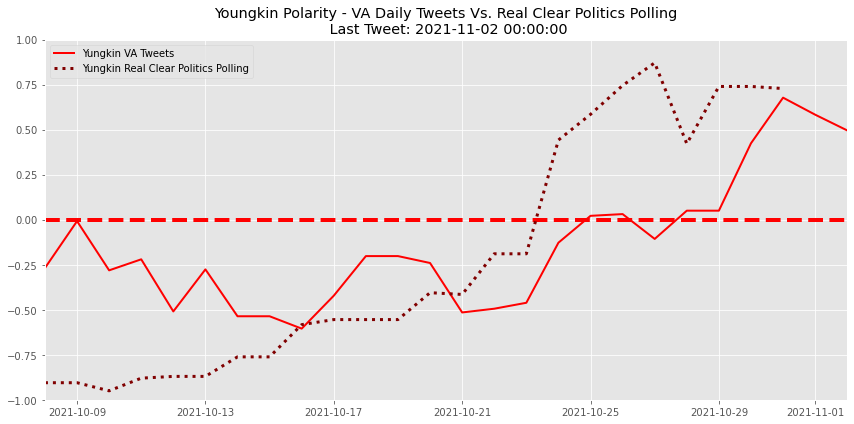

In [17]:
# fig, axes = plt.subplots(2,1, figsize=(14,10))
plt.figure(figsize=(12,6))

x = 'dailyPolarityAll'
y = 'dailyMaPolarityVa'
z = 'dailyPolarityRCP'

plt.style.use('ggplot')

# plt.plot(df['day'], df[f'{x}_rpol'],lw = 1, color='r', label='Yungkin All')
# plt.plot(df['day'], df[f'{x}_bpol'],lw = 1, linestyle="dotted", color='b', label = 'McAuliffe All')


plt.plot(df['day'], df[f'{y}_rpol_ffill'],lw = 2, color='red', label='Yungkin VA Tweets')
# plt.plot(df['day'], df[f'{y}_bpol_ffill'], lw = 2,linestyle="dotted",color='b', label = 'McAuliffe VA MA')

                           
plt.plot(df['day'], df[f'{z}_rpol'], lw=3, color='maroon',linestyle="dotted", label=f'Yungkin Real Clear Politics Polling')
# plt.plot(df['day'], df[f'{z}_bpol'], lw=3, linestyle="dotted",color='b', label = 'McAuliffe RCP')

                           
plt.title("\n".join([f'Youngkin Polarity - VA Daily Tweets Vs. Real Clear Politics Polling\n Last Tweet: {df.day.max()}']))

# axes[1].plot(df['day'],df['id'])
# axes[1].set_title("\n".join(['Tweets per day']))
plt.legend(loc='upper left')

xmin = list(df.day)[0]
xmax = list(df.day)[-1]

# Horizontal line at 0

plt.hlines(y= 0,  xmin=xmin, xmax=xmax,color='red', linestyle ='dashed', linewidth = 4)

plt.ylim(-1, 1)
plt.xlim(xmin, xmax)
plt.tight_layout()
plt.savefig('va_gov_VA_tweets_v_RCP_younkin.png',bbox_inches="tight")
plt.show()

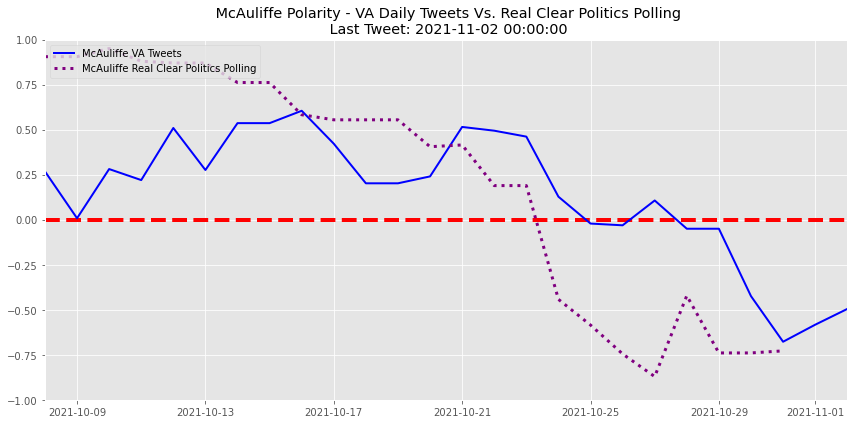

In [18]:
# fig, axes = plt.subplots(2,1, figsize=(14,10))
plt.figure(figsize=(12,6))

x = 'dailyPolarityAll'
y = 'dailyMaPolarityVa'
z = 'dailyPolarityRCP'

plt.style.use('ggplot')

# plt.plot(df['day'], df[f'{x}_rpol'],lw = 1, color='r', label='Yungkin All')
# plt.plot(df['day'], df[f'{x}_bpol'],lw = 1, linestyle="dotted", color='b', label = 'McAuliffe All')


# plt.plot(df['day'], df[f'{y}_rpol_ffill'],lw = 2, color='r', label='Yungkin VA MA')
plt.plot(df['day'], df[f'{y}_bpol_ffill'], lw = 2,color='b', label = 'McAuliffe VA Tweets')

                           
# plt.plot(df['day'], df[f'{z}_rpol'], lw=3, color='maroon', label=f'Yungkin RCP')
plt.plot(df['day'], df[f'{z}_bpol'], lw=3,linestyle="dotted",color='purple', label = 'McAuliffe Real Clear Politics Polling')


plt.title("\n".join([f' McAuliffe Polarity - VA Daily Tweets Vs. Real Clear Politics Polling\n Last Tweet: {df.day.max()}']))

# axes[1].plot(df['day'],df['id'])
# axes[1].set_title("\n".join(['Tweets per day']))
plt.legend(loc='upper left')

xmin = list(df.day)[0]
xmax = list(df.day)[-1]

# Horizontal line at 0
plt.hlines(y= 0,  xmin=xmin, xmax=xmax,color='red', linestyle ='dashed', linewidth = 4)

plt.ylim(-1, 1)
plt.xlim(xmin, xmax)
plt.tight_layout()
plt.savefig('va_gov_VA_tweets_v_RCP_mcauliffe.png',bbox_inches="tight")
plt.show()